In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray
from PIL import Image
import numpy as np
import cv2
import copy 

[[  0   0 189   0]
 [  0 189 189 189]
 [ 22  25 173  25]]
[[  0   0   0 189]
 [189   0 189 189]
 [ 22  25  22 171]]
[array([ 22, 171, 173,  25], dtype=int32)]


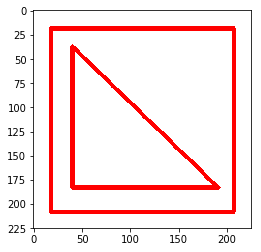

In [2]:
def same(arr1,arr2):
    r=10
    if abs(arr1[0]-arr2[0])<r and abs(arr1[1]-arr2[1])<r and abs(arr1[2]-arr2[2])<r and abs(arr1[3]-arr2[3])<r:
        return True
    else :
        return False
    
def samep(n1,n2):
    r=10
    if abs(n1-n2)<r:
        return True
    else:
        return False
    
    
def im_in(n, array):
    r=10
    for i in array:
        if abs(n-i)<r:
            return True
        
    return False
    
test = cv2.imread("test4.jpg")
white=cv2.imread('white4.jpg')
gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 200)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, minLineLength=0, maxLineGap=150)


new_lines=[]
for i in range(len(lines)):
    flag=0
    if (i!=0):
        for j in range(i):
                if same(lines[i][0],lines[j][0]):
                    flag=1
                    continue
    if(flag==0):
        new_lines.append(lines[i][0])

xs=[]
ys=[]

for i in new_lines:
    xs.append(i[0])
    xs.append(i[2])
    ys.append(i[1])
    ys.append(i[3])
    
    
sorted_x=sorted(xs)
sorted_y=sorted(ys)

special_x=[]
special_y=[]

for i in sorted_x:
    if not(im_in(i, special_x)):
        special_x.append(i)
    
for i in sorted_y:
    if not(im_in(i, special_y)):
        special_y.append(i)



r=10

for i in range(len(new_lines)):
    for j in range(len(special_x)):
        if(abs(new_lines[i][0]-special_x[j])<r):
            new_lines[i][0]=special_x[j]
            break
            
    for j in range(len(special_x)):
        if(abs(new_lines[i][2]-special_x[j])<r):
            new_lines[i][2]=special_x[j]
            break
    for j in range(len(special_y)):
        if(abs(new_lines[i][1]-special_y[j])<r):
            new_lines[i][1]=special_y[j]
            break
            
    for j in range(len(special_y)):
        if(abs(new_lines[i][3]-special_y[j])<r):
            new_lines[i][3]=special_y[j]
            break        
                
    
for i in range(len(new_lines)):   
    x1, y1, x2, y2 = new_lines[i]
    cv2.line(white, (x1, y1), (x2, y2), (255, 0, 0), 3)
#x1, y1, x2, y2 = new_lines[8]
#cv2.line(white, (x1, y1), (x2, y2), (255, 0, 0), 3)
#for i in new_lines:
#    print(i)
    
    
plt.imshow(white)




#FOR FARAG's HAPPINESS
minx=min(special_x)
maxy=max(special_y)
for i in range(len(new_lines)):
    new_lines[i][0]-=minx
    new_lines[i][2]-=minx
    
    new_lines[i][1]=maxy-new_lines[i][1]
    new_lines[i][3]=maxy-new_lines[i][3]

    
horizontal=[]
vertical=[]
general_line=[]

for i in new_lines:
    if i[0]==i[2]:
        vertical.append(i)
    elif i[1]==i[3]:
        horizontal.append(i)
    else:
        general_line.append(i)

horizontal = np.array(horizontal)
vertical = np.array(vertical)

print(horizontal)
print(vertical)
print(general_line)
# Show result
plt.imshow(white)

In [3]:
W